Model Testing & Feature Extraction for Recommendations



This notebook loads the trained autoencoder model and uses it to extract features from test images. It then recommends similar images using cosine similarity.

The notebook is structured as follows:

Import required libraries:
- Includes cv2, NumPy, tensorflow.keras, cosine_similarity from sklearn.
- Load and preprocess test images
- Resizes and normalizes test images similar to training step.
- Load trained autoencoder model
- Loads the saved model and extracts the encoder part.
- Generate image embeddings
- Passes test images through encoder to get compressed vectors.
- Recommend similar images
- Computes cosine similarity between embeddings and returns top-k similar images.


Top-11 similar products:

Product Name: Citizen Men Black Dial Watch
Image Link: http://assets.myntassets.com/v1/images/style/properties/e2002eef270ba0d84bc9d13be4f9b1c7_images.jpg



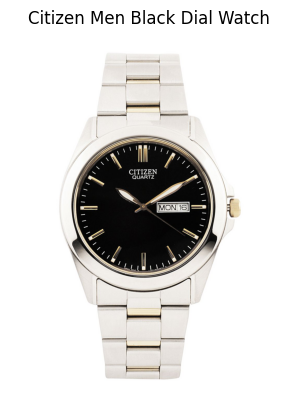

Product Name: Timex Men Black Dial Chronograph Watch
Image Link: http://assets.myntassets.com/v1/images/style/properties/Timex-Men-Black-Dial-Chronograph-Watch_f27f12ec2a4d8b9456057b54a7aa9052_images.jpg



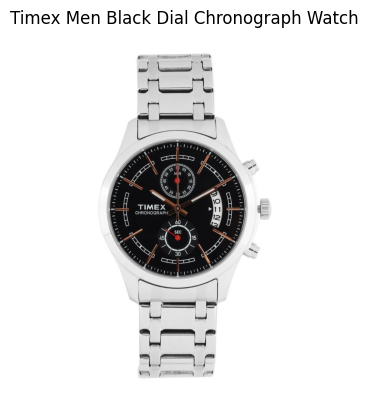

Product Name: Q&Q Men Black Dial Watch
Image Link: http://assets.myntassets.com/v1/images/style/properties/Q-Q-Men-Black-Dial-Watch_06c640e363cbb5af71d40c1690e85e1d_images.jpg



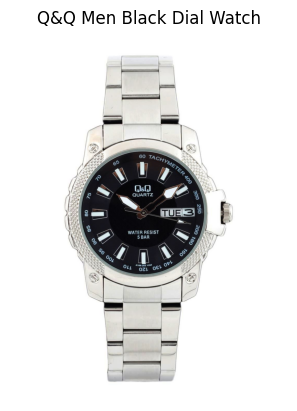

Product Name: Citizen Men Black Dial Watch BD0020-54E
Image Link: http://assets.myntassets.com/v1/images/style/properties/6e4f9413c46ba36bfd68e5294ec0a9b8_images.jpg



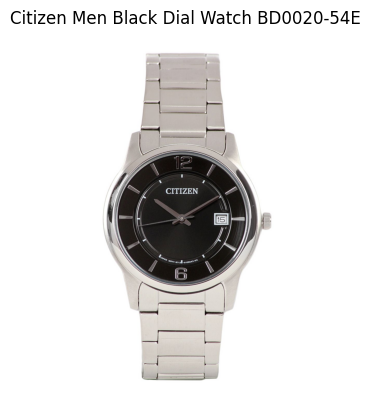

Product Name: Q&Q Men Black Dial Watch
Image Link: http://assets.myntassets.com/v1/images/style/properties/fada94ac267fc238f2b9fa89f7eb1aa9_images.jpg



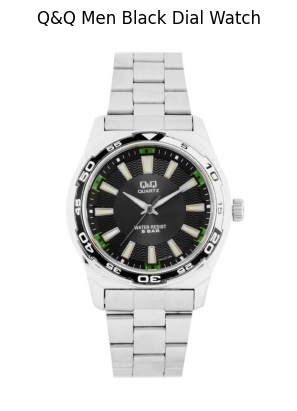

Product Name: Citizen Men Black Dial Watch BI0950-51E
Image Link: http://assets.myntassets.com/v1/images/style/properties/33104c996f56f7fe9da63e0eb54c0b99_images.jpg



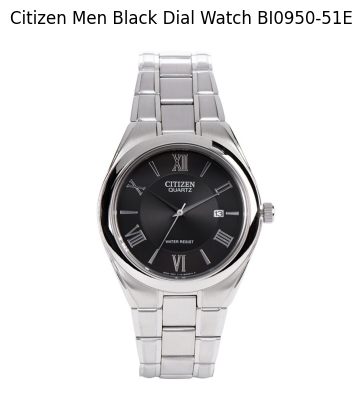

Product Name: Timex Men Black Dial Chronograph Watch
Image Link: http://assets.myntassets.com/v1/images/style/properties/Timex-Men-Black-Dial-Chronograph-Watch_a90db2158d7532313b48dc856dbee95f_images.jpg



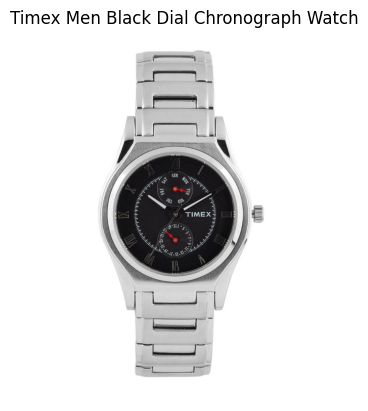

Product Name: Q&Q Men Black Dial Watch
Image Link: http://assets.myntassets.com/v1/images/style/properties/Q-Q-Men-Black-Dial-Watch_0c1ea9bff3e04e60203ef1c74c608759_images.jpg



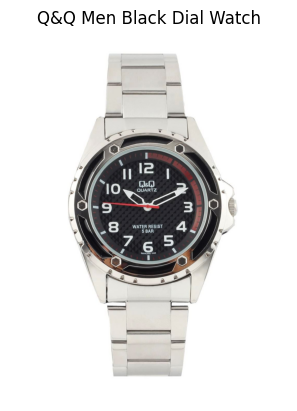

Product Name: Q&Q Men Black Dial Analogue Watch Q708J205Y
Image Link: http://assets.myntassets.com/v1/images/style/properties/Q-Q-Men-Black-Dial-Watch_b7b9a19d5dc5868eac56af1b841ddace_images.jpg



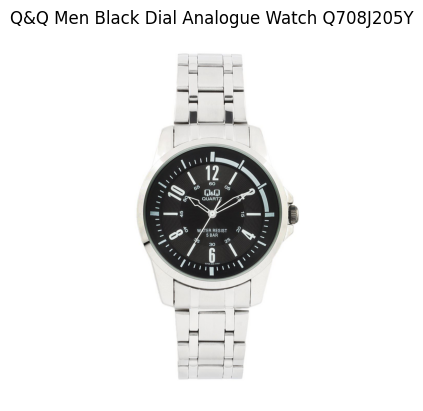

Product Name: Timex Men Blue Dial Watch
Image Link: http://assets.myntassets.com/v1/images/style/properties/Timex-Men-Blue-Dial-Watch_7aba3add6d404351bbc90064ba7a5dfa_images.jpg



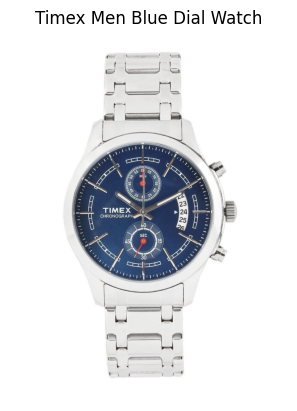

Product Name: Titan Men Blue Watch
Image Link: http://assets.myntassets.com/v1/images/style/properties/Titan-Men-Blue-Watch_e419d26808f989a39b6f1af018d4404f_images.jpg



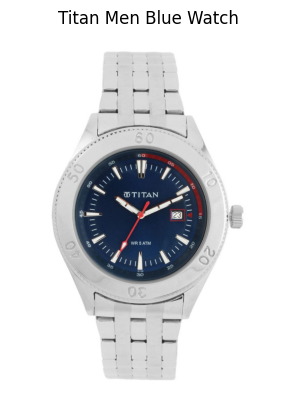

In [ ]:
import numpy as np
import pandas as pd
import os
import ast
from PIL import Image
from tensorflow.keras.models import load_model
from tensorflow.keras import models, layers
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import requests

# === CONFIG ===
MODEL_PATH = "backend/model/encoder_model.keras"
INPUT_SHAPE = (32, 32, 3)
CSV_PATH = "backend/output_features.csv"
TOP_N = 5

# === Step 1: Load Encoder ===
def build_encoder(input_shape):
    encoder = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2), padding='same'),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2), padding='same'),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu')
    ])
    return encoder

autoencoder = load_model(MODEL_PATH)
encoder = build_encoder(INPUT_SHAPE)

for i in range(len(encoder.layers)):
    encoder.layers[i].set_weights(autoencoder.layers[0].layers[i].get_weights())

# === Step 2: Preprocess Image ===
def preprocess_image(image_path, target_size=(32, 32)):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(target_size)
    img_array = np.array(img) / 255.0
    return np.expand_dims(img_array, axis=0)

# === Step 3: Load and Clean Feature DataFrame ===
df = pd.read_csv(CSV_PATH)

def safe_parse(x):
    try:
        arr = np.array(ast.literal_eval(x)) if isinstance(x, str) else x
        if arr.shape == (32,):  # Match encoder output
            return arr
    except:
        return None
    return None

df['image_features'] = df['image_features'].apply(safe_parse)
df = df.dropna(subset=['image_features']).reset_index(drop=True)

# === Step 4: Recommendation Function ===
def recommend_similar_products(input_img_path, top_n=TOP_N):
    input_img = preprocess_image(input_img_path)
    input_features = encoder.predict(input_img, verbose=0)[0].reshape(1, -1)

    feature_matrix = np.stack(df['image_features'].values)
    similarities = cosine_similarity(input_features, feature_matrix)[0]
    top_indices = np.argsort(similarities)[::-1][:top_n]

    print(f"\nTop-{top_n} similar products:\n")
    for idx in top_indices:
        row = df.iloc[idx]
        print(f"Product Name: {row['productDisplayName']}")
        print(f"Image Link: {row['link']}\n")

        try:
            display_img = Image.open(requests.get(row['link'], stream=True).raw)
            plt.imshow(display_img)
            plt.title(row['productDisplayName'])
            plt.axis('off')
            plt.show()
        except Exception as e:
            print(f"Could not display image: {e}\n")

# === Run with your input image ===
recommend_similar_products("fashion-dataset/images/33900.jpg", top_n=11)


Loads a pretrained encoder from an autoencoder model, preprocesses an input image, and uses cosine similarity on extracted features to recommend and display the top-N visually similar products from a dataset.
